## Understanding Loop Dataset
This notebook tries provides details on the structure of the Loop dataset and makes suggestions how to process the data.

## Loop

### The study
**Title**: An Observational Study of Individuals with Type 1 Diabetes Using the Loop System for Automated Insulin Delivery: The Loop Observational Study (LOS)

**Description**: Passive data collection to collect data on the efficacy, safety, usability, and quality of life/ psychosocial effects of the Loop System
    
**Devices**: insulin pump and a Dexcom or Medtronic CGM

**Study Population**: People of any age with Type 1 Diabetes

### Data
The study data folder is named **Loop study public dataset 2023-01-31**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

| File Name                     | Description                               | Note                                                                                           |
|-------------------------------|-------------------------------------------|-----------------------------------------------------------------------------------------------|
| **LOOPDeviceBasal<i>.txt**    | i=1-3, basal data exported from Tidepool | 3 files: 2.9GB, 2.9GB, and 1.35GB                                                             |
| **LOOPDeviceCGM<i>.txt**      | i=1-6, CGM data exported from Tidepool   | 6 files: 2.14GB, 2.24GB, 2.3GB, 2.31GB, 2.33GB, and 1.53GB.  Contains more patient IDs than Basal and Bolus files |
| **LOOPDeviceBolus.txt**       | Bolus data exported from Tidepool        | 1 file: 349MB                                                                                 |
| **PtRoster.txt**              | Patient Roster                           | Contains fixed UTC offsets which we need                                                     |

### Relevant Columns:
The following lists all relevant columns. Other columns were considered irrelevant. Some are still mentioned if they serve the discussion but crossed through.

#### LOOPDeviceCGM1-6
| Field_Name | Description | Note |
|----|----|-|
| **UTCDtTm** | Device date and time adjusted with timezone offset| These are UTC, the description is misleading! *1 |
| **RecordType**| Type of data (CGM, Calibration, etc)| Needed to drop calibrations|
| **CGMVal**| Glucose reading from the CGM (in mmol/L from Tidepool)| Convert to convert to mg/dl|
| ~~DeviceDtTm~~| Local device date and time; note not present in most rows because unavailable in Tidepool data source | *1 |
| ~~TmZnOffset~~| Timezone offset | *1 | 
| ~~Units~~ | Glucose reading units | all CGMs are in mmol/| 


#### LOOPDeviceBasal1-3

| Field Name | Glossary Description| Notes |
|-|-|-|
|**PtID**| Patient ID| Was not mentioned in glossary|
| **UTCDtTm**| Date and time with timezone offset| *1|
| **Rate** | Number of units per hour| **This is likely the only relevant value here**|
| ~~DeviceDtTm~~ | ~~Local device date and time; note not present in most rows because unavailable in Tidepool data source~~ |*1|
| ~~TmZnOffset~~ | ~~Timezone offset~~ | *1 | 
| BasalType| Basal delivery type | Unclear|
| Duration | Actual number of milliseconds basal will be in effect | Unclear |
| ExpectedDuration | Expected number of milliseconds basal will be in effect | Unclear|
| Percnt | Percentage of suppressed basal that should be delivered | Unclear|
| SuprBasalType| Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active) | Unclear, Ambiguous description. JAEB did not use these values (see Q&A with JAEB below) |
| SuprDuration | Suppressed duration |Unclear|
| SuprRate | Suppressed rate | Unclear|

Example (first row):  
| PtID   | UTCDtTm| **BasalType** | Duration | ExpectedDuration | Percnt | Rate  | **SuprBasalType** | SuprDuration | SuprRate | TmZnOffset | 
|---|---|---|---|---|---|---|---|---|---|---|
| 1082 | 2018-05-29 10:02:56| **temp**| 244000   ||| 1.475 | **scheduled**|| 1.600|| 


#### LOOPDeviceBolus
| Field_Name| Description | Note |
|-|-|-|
| **UTCDtTm**| Device date and time (with timezone offset) |*1|
| **BolusType**| Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)||
| **Normal** | Number of units of normal bolus |Likely the only relevant value.|
| ~~DeviceDtTm~~ | Local device date and time; note not present in most rows because unavailable in Tidepool data source |*1|
| ~~TmZnOffset~~ | Timezone offset |*1|
| ExpectedNormal | Expected number of units of normal bolus|Unclear|
| Extended | Number of units for extended delivery | We found that there are 0.4% extended boluses, probably triggered from the pump directly since Loop does not support these.|
| ExpectedExtended | Expected number of units for extended delivery|
| Duration | Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data) | Our analysis shows that Duration refers to the Extended part of a Bolus. However, unclear how to find out wether in ms or minutes. JAEB couldn't answer.|
| ExpectedDuration | Expected time span over which the bolus should have been delivered (milliseconds for Tidepool data, minutes for Diasend data) |

We asked JAEB:

**Suppressed Deliveries:** What are suppressed deliveries in the context of basal data?    
> Answer: **We do not know** what the suppressed deliveries represent in this context, and we did not use this information for our analyses.  We calculated TDI using the Rate and Duration variables.  We suggest reaching out to Tidepool for information on suppressed deliveries.

**Patient IDs Discrepancy:** Why are there more patient IDs in the CGM files than in the Basal and Bolus files?  
> If available, CGM data from the participant’s personal CGM was collected for the 3 months prior to enrollment. A number of participants provided the retrospective personal CGM data but did not use Loop/provide us with their Loop data.

**Time Zones:** The UTCDtTm field does not include timezone information and TmZnOffset is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of DeviceDtTm and the potential inaccuracy of PtTimezoneOffset? 
>When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.

**Dexcom Times:** Are Dexcom DexInternalDtTm times in local time or UTC?  
> We did not use this variable because it is missing for the majority of cases.  We believe that it was only available in downloads from personal CGMs but not available in the data uploaded by Tidepool.  It may be the local time but may need to reach out to Dexcom to confirm this.

**Data Source Identification:** How can we determine if the data is uploaded from Tidepool or Diasend, especially since this affects the interpretation of extended boluses?  
> In most cases (perhaps all), Tidepool uploads are indicated by the OriginName field being equal to ‘.com.apple.HealthKit’.  However, we suggest reaching out to Tidepool as there might be scenarios where Diasend was involved in the data chain.

 - [1]:DeviceDtTm and TmZnOffset are only available for a fraction of patients. Therefore, we rely on UTCDtTm and patient roster PtTimezoneOffset to obtain local time. 
 - [2]: Loop has no extended boluses, check what this is

### Todos:  
Boluses:  
 - Need to check if the Normal portion is the actual delivered by comparing the values (<= in all cases would prove this to be true).
 - Check if there are extended boluses
 - Can we determine the delivery duration (ms or minutes) based on the data source?
Basals:
 - Need to double check if the Suppressed values are already factored in and if standard basal rates are reported as well.
 - Check potential values for columns like basal type (value-counts)


## Import

In [1]:
import os, sys
from datetime import datetime, timedelta, timezone
import time
import numpy as np
import pandas as pd
from dask import dataframe as dd

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from src import postprocessing
from dask.distributed import Client
client = None
if not client:
    client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 36.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50208,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 36.00 GiB
Comm: tcp://127.0.0.1:50221,Total threads: 3
Dashboard: http://127.0.0.1:50224/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:50211,


In [3]:
#define path variables
study_name = 'Loop study public dataset 2023-01-31'
raw_path = os.path.join(os.getcwd(), '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', 'data', 'out')
loop_path = os.path.join(raw_path, study_name)
df_patient= pd.read_csv(os.path.join(loop_path, 'Data Tables', 'PtRoster.txt'), sep='|')
loop_paquet_path = os.path.join(raw_path, 'paquet', study_name) 

## Datetime Analysis (using CGM subset)
We start by working with CGM data to understand how to obtain local datetimes. 

As we can see below, 
- **Datetimes:** DeviceDtTm and TmznOffset are mostly NaN, as discussed with JAEB, these are the only cases where we have true (int the sense of device reported) information about local datetime and the actual time zone offset.
 - **Memory usage:** 1GB for a single CGM file is too much. The patient data is spread accross various files which requires out of memory approaches.

In [6]:
#inspect LOOPDeviceCGM1.txt, one of 6 CGM files.
df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',
                     usecols=['PtID', 'DeviceDtTm', 'TmZnOffset', 'UTCDtTm', 'RecordType', 'CGMVal', 'Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (before optimization)")

#optimize data by storage size
df_cgm['UTCDtTm'] = pd.to_datetime(df_cgm.UTCDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['DeviceDtTm'] = pd.to_datetime(df_cgm.DeviceDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['TmZnOffset'] = pd.to_timedelta(df_cgm.TmZnOffset, unit='minute')

df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM'].drop(columns=['RecordType'])
df_cgm = df_cgm.drop(columns=['Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (after optimization)")

def count_na(series):
    return series.isna().sum()
display(df_cgm.agg(['count', count_na, 'nunique']).T)

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_48568/3485888083.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',


Memory usage: 1010.96 MB (before optimization)
Memory usage: 865.75 MB (after optimization)


,count,count_na,nunique
PtID,18912614,0,589
DeviceDtTm,6128194,12784420,5629581
UTCDtTm,18912614,0,14581839
CGMVal,18912614,0,315660
TmZnOffset,5917165,12995449,15


### Understanding Datetimes
Are these local times? This is what the glossary says:
 - `DeviceDtTm`: Local device date and time; note not present in most rows because unavailable in Tidepool data source
 - `UTCDtTm`: Device date and time adjusted with timezone offset
 -`DexInternalDtTm` Dexcom Internal date and time
 -`TmZnOffset`: Timezone offset

While we assume ```DeviceDtTm = UTCDtTm + TmZnOffset``` the glossary is a little ambiguous so we plot patient data and the distribution.


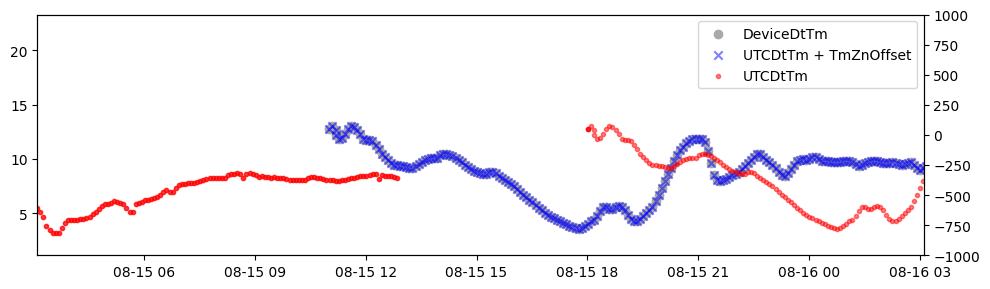

In [ ]:
#ploting a single patient's CGM data
pt_grps = df_cgm.groupby('PtID', observed=False)
subframe = pt_grps.get_group(1173).copy()
subframe['AdjustedDtTm'] = subframe.UTCDtTm + pd.to_timedelta(subframe.TmZnOffset, unit='minute')

temp = subframe.dropna(subset=['DeviceDtTm']).sort_values(['DeviceDtTm'])

fig, ax = plt.subplots(figsize=(10, 3)); twinx = ax.twinx()
offset=4.5

ax.scatter(temp.DeviceDtTm, temp.CGMVal, label='DeviceDtTm', marker='o',alpha=1, color='darkgray')
ax.scatter(temp.AdjustedDtTm, temp.CGMVal, label='UTCDtTm + TmZnOffset', marker='x', alpha=0.5,color='blue')

temp = subframe.dropna(subset=['UTCDtTm']).sort_values(['UTCDtTm'])
ax.scatter(temp.UTCDtTm, temp.CGMVal, label='UTCDtTm', marker='.',alpha=0.5,color='red')
twinx.plot(temp.UTCDtTm, temp.TmZnOffset, label='TmZnOffset')

ax.set_xlim(temp.UTCDtTm.min()+timedelta(days=offset), temp.UTCDtTm.min()+timedelta(days=offset+1))
twinx.set_ylim(-1000, 1000); ax.legend(); plt.tight_layout()
plt.show()
del subframe, temp

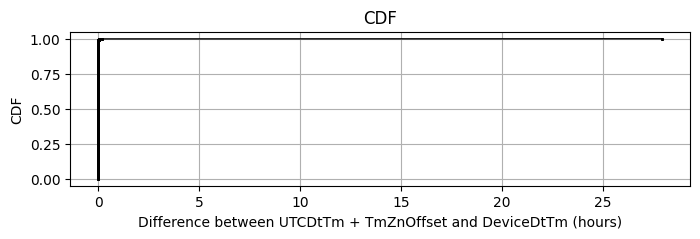

In [ ]:
# plot the difference between UTCDtTm + TmZnOffset and DeviceDtTm
temp = df_cgm.sample(10000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)

temp.loc[:,'Diff'] = (temp.DeviceDtTm - (temp.UTCDtTm + pd.to_timedelta(temp.TmZnOffset, unit='minute'))).dt.total_seconds()/3600

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(temp.Diff.abs(), xlabel='Difference between UTCDtTm + TmZnOffset and DeviceDtTm (hours)', ax=ax)

(Note: We see that some differences are not equal to zero. In these cases, the time shift is a fraction of hours. We don't know why that is.)

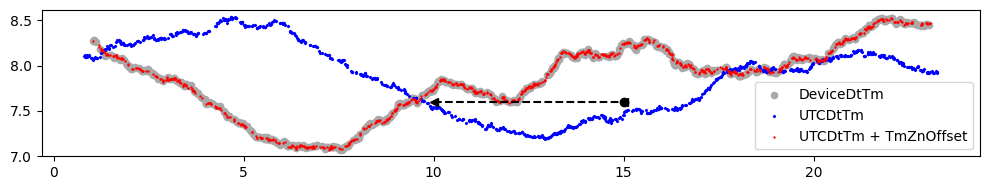

In [7]:
#plot daytime average CGM values

#reduce data to those with values in both timestamp columns
temp = df_cgm.sample(100000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['datetime'] = pd.to_datetime(temp.UTCDtTm) + pd.to_timedelta(temp.TmZnOffset, unit='minute')

#calculate the hour of day for each timestamp
temp['DeviceDtTm_hod'] = temp.DeviceDtTm.dt.hour+temp.DeviceDtTm.dt.minute/60+temp.DeviceDtTm.dt.second/3600
temp['UTCDtTm_hod'] = temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600
temp['datetime_hod'] = temp.datetime.dt.hour+temp.datetime.dt.minute/60+temp.datetime.dt.second/3600

#calcualte centered moving average
window = 2000
ma_DeviceDtTm  = temp[['CGMVal','DeviceDtTm_hod']].sort_values('DeviceDtTm_hod').rolling(window=window, min_periods=window, on='DeviceDtTm_hod', center=True).mean().sample(1000)
ma_UTCDtTm  = temp[['CGMVal','UTCDtTm_hod']].sort_values('UTCDtTm_hod').rolling(window=window, min_periods=window, on='UTCDtTm_hod', center=True).mean().sample(1000)
ma_datetime  = temp[['CGMVal','datetime_hod']].sort_values('datetime_hod').rolling(window=window, min_periods=window, on='datetime_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(ma_DeviceDtTm.DeviceDtTm_hod, ma_DeviceDtTm.CGMVal, label='DeviceDtTm', color='darkgray', marker='o',s=20)
plt.scatter(ma_UTCDtTm.UTCDtTm_hod, ma_UTCDtTm.CGMVal, label='UTCDtTm', color='blue', marker='x',s=2)
plt.scatter(ma_datetime.datetime_hod, ma_datetime.CGMVal, label='UTCDtTm + TmZnOffset', color='red', marker='.',s=2)

plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


From this we can clearly see that 

1. DeviceDtTm and the offset compensated utc aligns with expected diurnal, postprandial patterns (pronounced peak in the morning, noon and evening). 
2. Using UTC alone (blue), the peaks are less pronounced and roughly offset by 5 hours (black arrow) (At UTC 15:00 we see the morning peak, which really is at around 10:00 (-5h). This is in line with the fact that the majority of time zone offsets is around -300 minutes (-5hours). Note that just compensating UTC by 5 hours does not give the same pronounced peaks, since there are users with other offsets, the peaks are washed out.

We can conclude that ```DeviceDtTm = UTCDtTm + TmZnOffset``` with DeviceDtTm being the local time. And that the glossary description *"UTCDtTm : Device date and time (with timezone offset)"* is misleading.


However, we can **not rely** on DeviceDtTm and TmZnOffset because it only exists for a fraction of the data. Therefore we need to rely on UTCDtTm and either  
 * extrapolate TmZnOffset
 * use the patient roster time zone offsets

### Which Offset to use?

One option would be to extrapolate the `TmZnOffset` (bfill/ffill)? To check if this is a viable option we check how many patients have TmZnOffset data.  We do this by checking the fraction of patients with at least one TmZnOffset value. As we can see below, this is clearly not enough. 

37.18% of patients have at least one timezone offset


Text(0.5, 1.0, 'Availability of timezone offsets for patients with at least one')

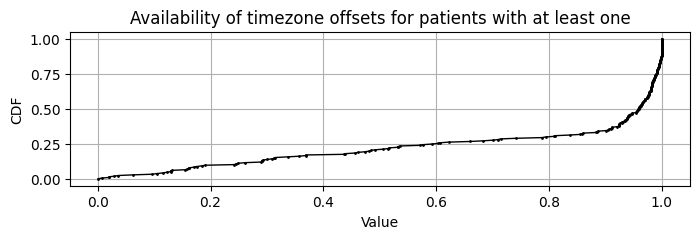

In [ ]:
#check fraction of patients with at least one timezone offset
frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()
print(f'{frac:.2%} of patients have at least one timezone offset')

#check fraction of non NaN offsets for patients with at least one
pts_with_data = df_cgm.dropna(subset=['TmZnOffset'] ).PtID.unique()
temp = df_cgm.loc[df_cgm.PtID.isin(pts_with_data)]
temp = temp.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())

plt.figure(figsize=(8,2)); ax = plt.gca()
cdf.plot_cdf(temp,ax=ax)
plt.title('Availability of timezone offsets for patients with at least one')

Instead, we could use the `PtTimezoneOffset` (utc offset in hours) from the patient roster. To understand if using this *static* value is acceptable, we want to understand how often the actual timezone changes.

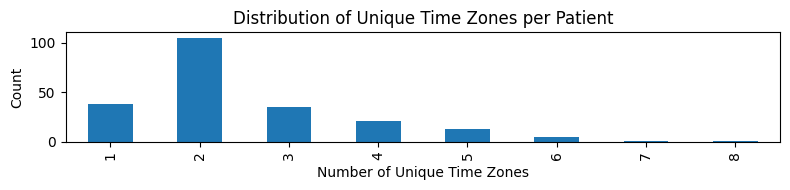

65.3% of patients have 2 unique time zones or less


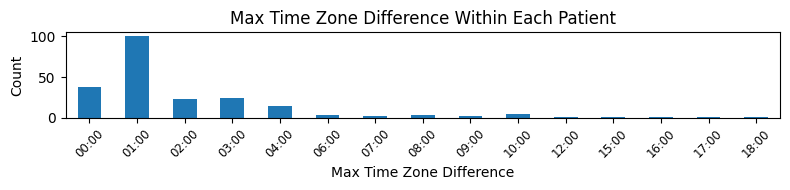

63.0% of patients have shifts of 1 hours or less


In [8]:
#report time zone offsets and changes within patients
def timedetla_formatter(td):
    return f"{td.seconds // 3600 + td.days * 24:02d}:{(td.seconds % 3600) // 60:02d}"

#number of time zones per patient
number_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.nunique()
number_time_zones = number_time_zones.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
number_time_zones.plot(kind='bar', ax=ax)
plt.xlabel('Number of Unique Time Zones')
plt.ylabel('Count')
plt.title('Distribution of Unique Time Zones per Patient')
plt.tight_layout(); plt.show()

print(f'{100*number_time_zones.loc[0:2].sum()/number_time_zones.sum():2.1f}% of patients have 2 unique time zones or less')


#max difference within a patient
tzdiff_within = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.agg(lambda x: x.max()-x.min())
tzdiff_within = tzdiff_within.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
tzdiff_within.plot(kind='bar', ax=ax)
tick_labels = [timedetla_formatter(x) for x in tzdiff_within.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')
plt.xlabel('Max Time Zone Difference');plt.ylabel('Count')
plt.title('Max Time Zone Difference Within Each Patient')
plt.tight_layout();plt.show()

print(f'{100*tzdiff_within[tzdiff_within.index<=timedelta(hours=1)].sum()/tzdiff_within.sum():2.1f}% of patients have shifts of 1 hours or less')


# #Which time zones exist?
# all_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.unique().explode()
# plt.figure(figsize=(8, 2)); ax=plt.gca()
# all_time_zones= all_time_zones.value_counts().sort_index()
# all_time_zones.plot(kind='bar', logy=True, ax=ax)
# tick_labels = [timedetla_formatter(x) for x in all_time_zones.index]
# ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')

# plt.xticks(rotation=45, fontsize='small')
# plt.xlabel('Time Zone Offset'); plt.ylabel('Count'); plt.title('Distribution of Time Zone Offsets')
# plt.tight_layout();plt.show()

#### Estimate static time zone error

We see that 
 - Majority of most patients experience more than 1 time zones.
 - The majority is a change of 1 hour. Likely the result of daylight saving times. 
- But, a significant fraction experiences changes of 2,3 or 4 hours or more. This is nothing, that we could account for. While we can remove patients with more frequent changes in `TmZnOffset`, almost 2/3 of the patients have no data in that column. 

However, these time zone changes are likely infrequent as most patients will travel for short periods only. Let's estimate the expected error. To estimate the error, we compare the static offsets from the patient roster with the device reported offsets for those user that have it.

In [9]:
## obtaining local times from utc and patient roster offsets

# joining tables
df_patient['PtTimezoneOffset'] = pd.to_timedelta(df_patient.PtTimezoneOffset, unit='hour')
df_cgm = df_cgm.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), on='PtID', how='left')

# converting to localized datetime
#method 1: getting localized datetimes (much slower)
#df_cgm['datetime'] = pd.to_datetime(df_cgm.UTCDtTm, utc=True)
#df_cgm['datetime'] = df_cgm.apply(lambda x: x.datetime.tz_convert(timezone(offset=x.PtTimezoneOffset)), axis=1)

#method 2: or as naive datetime (simply adding the offset)
df_cgm['datetime']= df_cgm.UTCDtTm+ df_cgm.TmZnOffset
#display(df_cgm.dropna(subset=['TmZnOffset']).sample(3))

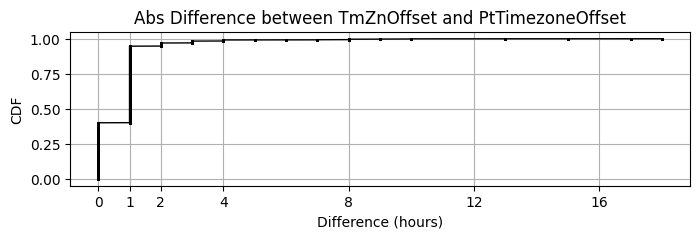

In [10]:
#plotting the difference between CGM TmZnOffset and PtTimezoneOffset

diff = df_cgm.TmZnOffset - df_cgm.PtTimezoneOffset
diff = abs(diff.dropna().dt.total_seconds()/3600)

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(diff,ax=ax); plt.xlabel('Difference (hours)');
plt.title('Abs Difference between TmZnOffset and PtTimezoneOffset');
plt.xticks([0,1,2,4,8,12,16]); #plt.tight_layout(); plt.show()

#get cumulative stats
# print(f'{(diff>=2).mean():.1%} of time zone differences are >2 hours')
# error_counts = diff.value_counts(bins=[-1, 0, 1, 2, 3, 4, float('inf')], sort=False)
# error_percentages = (error_counts / error_counts.sum()) * 100
# error_percentages.name = 'Percentage'
# cumsum_report = error_percentages.cumsum()
# cumsum_report.name = 'Cumulative Percentage'
# cumsum_report.index = [f'<={x.right:.0f}' for x in error_counts.index]
# display(cumsum_report)

This doesn't look too bad.  When using the static patient roster utc offset, the local time error will be <2 hours for >96% of the cases.

### Conclusion
Local datetimes can be obtained with a small estimated error (<2 hours for >96% of the cases) by using the patient roster static time zone utc offsets PtTimezoneOffset and UTCDtTm utc timestamps. 

```local_time = UTCDtTm + PtTimezoneOffset```

## CGM

### Loading using dask


Processing patient data requires us to load all files into memory at once because the patient data is spread accross all CGM files. While we could use dask on the csvs directly, this would create a lot of overhead (shuffling to perform grouped conversions). 
Instead, we convert the data into a paquet format, splitting it by patient id. This allows us to process patients iteratively and in parallel.

In [16]:
## export CGM to parquet if not already done
re_export = False
cgm_parquet_path = os.path.join(loop_paquet_path, 'cgm')

if not os.path.exists(cgm_parquet_path):
    temp = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])
    temp.to_parquet(os.path.join(loop_paquet_path,'cgm'), partition_on='PtID')
else:
    print(f'Parquet files already exist in {loop_paquet_path}')

Parquet files already exist in /Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/paquet/Loop study public dataset 2023-01-31


In [4]:
#load parquet and a subset
ddf_cgm = dd.read_parquet(os.path.join(loop_paquet_path,'cgm'), aggregate_files='PtID')
df_cgm_sample = ddf_cgm.sample(frac=0.1).compute().reset_index()

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 9.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 14.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [41]:
#display the COLUMNS
print('COLUMNS:')
print(df_cgm_sample.columns)

COLUMNS:
Index(['index', 'UTCDtTm', 'RecordType', 'CGMVal', 'PtID'], dtype='object')


### Check for Magic CGM Values

Let's check on CGM distribution. As we can see below, 0 and 400 CGM values are capped (as expected) but no 0 values exist.

Number of values around 0: 0


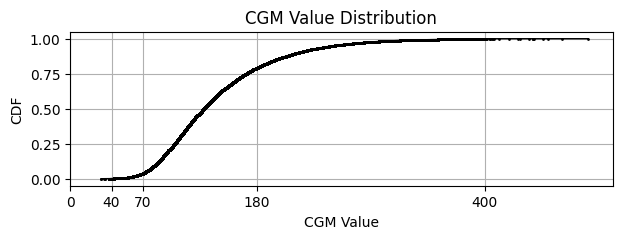

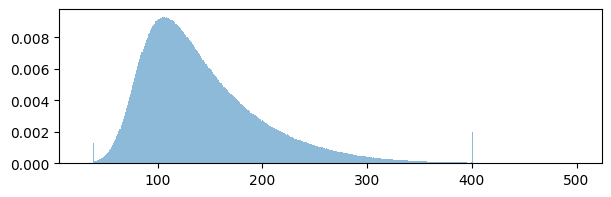

In [32]:
#Visualize CGM Distribution
#R = ddf_cgm.map_partitions(lambda x: x.CGMVal.sample(n=min(1000,len(x)))).compute()
print(f"Number of values around 0: {((df_cgm_sample.CGMVal<1) & (df_cgm_sample.CGMVal>-1)).sum()}")
plt.figure(figsize=(7, 2)); ax = plt.gca()
cdf.plot_cdf(df_cgm_sample.CGMVal*18, xlabel='CGM Value', ylabel='CDF', title='CGM Value Distribution',ax=ax)
plt.xticks([0,40,70,180,400]);

plt.figure(figsize=(7, 2)); ax = plt.gca()
vc = (df_cgm_sample.CGMVal*18).round().value_counts(normalize=True).sort_index()
plt.bar(vc.index,vc.values, width=1, alpha=0.5);
del vc

### Duplicates

In [38]:
#print duplicates
def report_duplicates(ddf, subset, sort_by):
    # Combine duplicated counts into a single computation
    def count_duplicates(df, subset=None):
        return df.duplicated(subset=subset).sum()

    # Map partitions once and compute all duplicates
    duplicate_counts = ddf.map_partitions(lambda x: {
        "all": count_duplicates(x),
        "subset": count_duplicates(x, subset=subset)
    }).compute()

    # Aggregate results
    total_duplicates_all = sum(d["all"] for d in duplicate_counts)
    total_duplicates_subset = sum(d["subset"] for d in duplicate_counts)

    # Print results
    print(f'{total_duplicates_all} duplicates ({100 * total_duplicates_all / len(ddf):.2f}%)')
    print(f'{total_duplicates_subset} duplicates ({100 * total_duplicates_subset / len(ddf):.2f}%) {subset}')

    # Sample first partition for display
    df = ddf.partitions[0].compute()
    bDuplicated = df.duplicated(keep=False)
    display(df[bDuplicated].sort_values(sort_by).head(2))
 
report_duplicates(ddf_cgm, ['UTCDtTm'], ['UTCDtTm'])

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


19628647 duplicates (17.66%)
21857113 duplicates (19.67%) ['UTCDtTm']


,UTCDtTm,RecordType,CGMVal,PtID
143914,2018-10-14 17:03:08,CGM,6.93843,3
143915,2018-10-14 17:03:08,CGM,6.93843,3


#### Check for correlation

In [ ]:
duplicated_cgms = ddf_cgm.map_partitions(lambda x: x[x.duplicated(subset=['UTCDtTm'], keep=False)].sort_values('UTCDtTm').head(100)).compute()

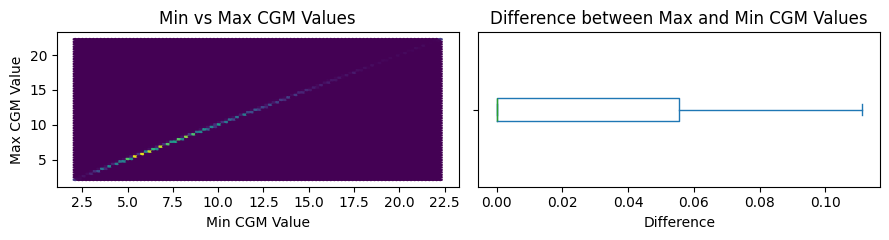

In [89]:
duplicated_cgms['PtID'] = duplicated_cgms.PtID.astype('str')
duplicated_cgms = duplicated_cgms.sort_values(['PtID','UTCDtTm'])
results = duplicated_cgms.groupby(['PtID','UTCDtTm']).CGMVal.agg(['min','max'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

# Scatter plot
ax1.hexbin(results['min'], results['max'], gridsize=100, cmap='viridis')
ax1.set_xlabel('Min CGM Value')
ax1.set_ylabel('Max CGM Value')
ax1.set_title('Min vs Max CGM Values')

# Box plot
d = (results['max'] - results['min'])
d.plot.box(vert=False, ax=ax2, showfliers=False)
ax2.set_title('Difference between Max and Min CGM Values')
ax2.set_xlabel('Difference')

plt.tight_layout()
plt.show()

### Missing Data

In [47]:
#print NaNs and Record Type fractions
print('NAN VALUES:')
temp = df_cgm_sample.isna().sum()
print(f"overall nan values = {temp.sum()}")
display(100*temp/len(df_cgm_sample))

print('Record Type:')
display(df_cgm_sample.value_counts(subset=['RecordType'])*100/len(df_cgm_sample))
del temp

NAN VALUES:
overall nan values = 0


index         0.0
UTCDtTm       0.0
RecordType    0.0
CGMVal        0.0
PtID          0.0
dtype: float64

Record Type:


RecordType 
CGM            99.947317
Calibration     0.052683
Name: count, dtype: float64

### CGM Conclusion
- Many duplicates that need to be dropped
 - CGM Data must be converted from mmols to mg/dl
 - There are no NaN values
 - Calibrations need to be dropped
 


### Extract CGM based on learnings

In [48]:
# Extract CGM data based on what we learned using Dask
#read CGM files, partitioned by PtID
ddf_cgm_extract = ddf_cgm.rename(columns={'PtID': 'patient_id', 'UTCDtTm': 'UTCDtTm', 'RecordType': 'RecordType', 'CGMVal': 'cgm'})
ddf_cgm_extract = ddf_cgm_extract.set_index('patient_id')#,drop=False) # make sure divisions are set correctly, keep patient_id as column

#drop calibrations
ddf_cgm_extract = ddf_cgm_extract.loc[ddf_cgm_extract.RecordType == 'CGM']
ddf_cgm_extract.index = ddf_cgm_extract.index.astype('int') #a workaround to obmit error occuring when there were no rows left
ddf_cgm_extract = ddf_cgm_extract.drop(columns=['RecordType'])

#convert to mg/dL
ddf_cgm_extract['cgm'] = ddf_cgm_extract.cgm*18.018 

#convert utc to local datetime
#TODO: When i do not rename PTID here, then result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform); result.loc[3].compute().head(10); 
# will fail with 'KeyError: 'patient_id' this is weird because ddf.index.name still yields patient_id
patient_roster = df_patient[['PtID','PtTimezoneOffset']].rename(columns={'PtID':'patient_id'}).set_index('patient_id')
ddf_cgm_extract = ddf_cgm_extract.join(patient_roster, how='left')
ddf_cgm_extract['datetime'] = ddf_cgm_extract.UTCDtTm + dd.to_timedelta(ddf_cgm_extract.PtTimezoneOffset, unit='hour')
ddf_cgm_extract = ddf_cgm_extract.drop(columns=['UTCDtTm', 'PtTimezoneOffset'])


In [40]:
# Resample subset of CGM data using dask

#Method 1: using groupby: this works but only if we previously renamed the PtID of the patient roster index to 'patient_id' before the join
meta={'datetime': 'datetime64[ns]', 'cgm': 'float64'}
result = ddf_cgm_extract.groupby(by='patient_id').apply(postprocessing.cgm_transform, meta=meta)
display(result.loc[3].compute().head(5))

del meta, result

#Method 2: using map_partitions: this works but we loose the patient index, workaround:
# def wrapper(df):
#     assert df.index.nunique() == 1
#     r= postprocessing.cgm_transform(df)
#     r.assign('patient_id', df.index[0])

# start_time = time.time()    
# loop_cgm_transformed = ddf_cgm.map_partitions(postprocessing.cgm_transform, meta=meta)
# transformed_partition = loop_cgm_transformed.get_partition(0).compute()
# display(transformed_partition.head(10))
# end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
[16:43:10] The index is not sorted. Sorting the index.


datetime         cgm
patient_id                                  
3          0 2018-06-15 19:00:00  396.516721
           1 2018-06-15 19:05:00  394.273480
           2 2018-06-15 19:10:00  387.947360
           3 2018-06-15 19:15:00         NaN
           4 2018-06-15 19:20:00  338.812274

## Boluses

In [128]:
#read bolus as pandas dataframe (it is small enough)
df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S')
df_bolus = df_bolus.drop(columns=['RecID'])

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_50366/3861500938.py:2: DtypeWarning: Columns (3,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|',


In [120]:
## Report Columns, Nans, Duplicates, 
def report_duplicates(df, subset, sort_by):    
    bDuplicated = df.duplicated(keep=False)
    print(f'{bDuplicated.sum()} duplicates ({100*bDuplicated.sum()/len(df):.2f}%)')
    print('Duplicated rows:')
    display(df[bDuplicated].dropna(axis=1).sort_values(sort_by).head(2))
    

    bDuplicated = df.duplicated(subset=subset, keep=False)
    print(f'{bDuplicated.sum()} duplicates ({100*bDuplicated.sum()/len(df):.2f}%) {subset}')
    print(f'Duplicated rows subset {subset}:')
    display(df[bDuplicated].dropna(axis=1).sort_values(sort_by).head(2))
    

#print stats for bolus dataframe
print('COLUMNS:')
print(df_bolus.columns)

#display the value counts
print('VALUE FRACTIONS:')
display(df_bolus.value_counts(subset=['BolusType'])*100/len(df_bolus))

#display the nan values
print('NAN FRACTIONS')
display(100*df_bolus.isna().sum()/len(df_bolus))

print('DUPLICATES:')
report_duplicates(df_bolus, ['UTCDtTm', 'PtID'], ['UTCDtTm'])


COLUMNS:
Index(['PtID', 'ParentLOOPDeviceUploadsID', 'DeviceDtTm', 'UTCDtTm',
       'BolusType', 'Normal', 'ExpectedNormal', 'Extended', 'ExpectedExtended',
       'Duration', 'ExpectedDuration', 'TmZnOffset', 'OriginName',
       'OriginVers', 'OriginType', 'OriginDeviceFirmwrVer',
       'OriginDeviceHardwrVer', 'OriginDeviceManufact', 'OriginDeviceModel',
       'OriginOperatingSystVer', 'OriginProductType'],
      dtype='object')
VALUE FRACTIONS:


BolusType  
normal         99.572622
dual/square     0.362914
square          0.064464
Name: count, dtype: float64

NAN FRACTIONS


PtID                          0.000000
ParentLOOPDeviceUploadsID     0.000000
DeviceDtTm                   93.685623
UTCDtTm                       0.000000
BolusType                     0.000000
Normal                        0.064464
ExpectedNormal               99.442838
Extended                     99.572622
ExpectedExtended             99.926316
Duration                     99.572622
ExpectedDuration             99.926316
TmZnOffset                   93.685623
OriginName                    6.314377
OriginVers                    6.314499
OriginType                    6.314377
OriginDeviceFirmwrVer        10.168242
OriginDeviceHardwrVer        99.903264
OriginDeviceManufact          7.290022
OriginDeviceModel             7.290022
OriginOperatingSystVer        6.314377
OriginProductType             6.314377
dtype: float64

DUPLICATES:
0 duplicates (0.00%)
Duplicated rows:


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,...,TmZnOffset,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceHardwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType


72891 duplicates (2.97%) ['UTCDtTm', 'PtID']
Duplicated rows subset ['UTCDtTm', 'PtID']:


,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType
1909538,993,1166915,2017-11-14 18:37:40,normal
1909540,993,1166915,2017-11-14 18:37:40,normal


BOPLUS TYPES:


BolusType
normal         2440519
dual/square       8895
square            1580
Name: count, dtype: int64

### Duplicates
As we can see above, there are significant amount of duplicates and that most duplicated rows are completely identical (except for the record id). 
However, we also see slightly more duplicates when using ['UTCDtTm', 'PtID'] as subset. This means that there are rows that have equal  ['UTCDtTm', 'PtID'] but vary otherwise. Let's check when this happens:

In [104]:
df_bolus = df_bolus.drop_duplicates()
b_duplicated_subset = df_bolus.duplicated(subset=['UTCDtTm','PtID'], keep=False)
print(f'{b_duplicated_subset.sum()} duplicates ({100*b_duplicated_subset.sum()/len(df_bolus):.2f}%) UTCDtM, PtID')
del b_duplicated_subset

In [141]:
df_bolus[b_duplicated_subset].sort_values(['PtID', 'UTCDtTm']).head(2).dropna(axis=1, how='all')

,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType,Normal,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
437671,3,1300475,2018-10-16 13:56:29,normal,0.3,com.apple.HealthKit,55,service,2.7.0,Insulet,Eros,12.2.0,"iPhone10,4"
1705687,3,1300475,2018-10-16 13:56:29,normal,0.3,com.apple.HealthKit,55,service,2.8.0,Insulet,Eros,12.2.0,"iPhone10,4"


Here we see differences in the firmware. But are there also duplicates with different bolus doses?

In [142]:
# Print some duplicated rows with different boluses
duplicated_rows = df_bolus[df_bolus.duplicated(subset=['PtID', 'UTCDtTm'], keep=False)]
different_normal = duplicated_rows.groupby(['PtID', 'UTCDtTm']).filter(lambda x: x['Normal'].nunique() > 1)
display(different_normal.sort_values(['PtID', 'UTCDtTm']).head(2).dropna(axis=1, how='all'))
del duplicated_rows

,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType,Normal,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
583713,4,1312477,2019-01-10 01:22:31,normal,15.0,com.apple.HealthKit,54,service,subg_rfspy 0.9,Medtronic,722,12.2.0,"iPhone11,6"
583714,4,1312477,2019-01-10 01:22:31,normal,9.2,com.apple.HealthKit,54,service,subg_rfspy 0.9,Medtronic,722,12.2.0,"iPhone11,6"


We see that there are instances where we have temporal duplicates with different values and it is unclear which one to trust.

#### Check for Correlation

count    365740.000000
mean          0.001341
std           0.084520
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.600000
dtype: float64

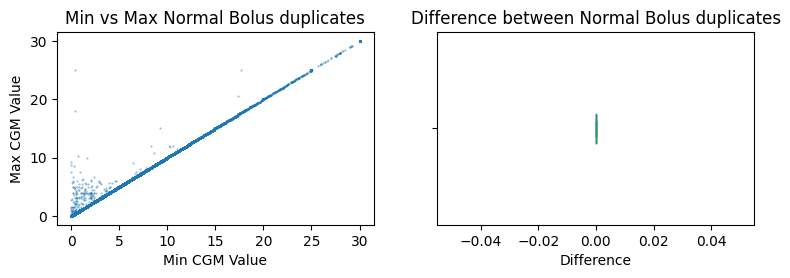

In [100]:
duplicated_boluses = df_bolus[df_bolus.duplicated(subset=['UTCDtTm'], keep=False)].sort_values('UTCDtTm')

results = duplicated_boluses.groupby(['PtID','UTCDtTm']).Normal.agg(['min','max'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

# Scatter plot
ax1.scatter(results['min'], results['max'],alpha=0.5,s=1,marker='.')
ax1.set_xlabel('Min CGM Value')
ax1.set_ylabel('Max CGM Value')
ax1.set_title('Min vs Max Normal Bolus duplicates')

# Box plot
d = (results['max'] - results['min'])
d.plot.box(vert=False, ax=ax2, showfliers=False)
ax2.set_title('Difference between Normal Bolus duplicates')
ax2.set_xlabel('Difference')

d.describe()

We see that sometimes boluses are drastically different. We don't know why that is and we wouldn't know which value to pick.

### Dual wave Boluses
We know there are some dual wave and extended boluses. Since loop does not support these natively, these were likey initiated from the pump or during open loop mode.

In [121]:
#print the fraction of extended boluses
print(f'{100*df_bolus.Extended.notna().mean():.2f}% of boluses are extended')
print(f'In {(df_bolus.Extended.notna() == df_bolus.Duration.notna()).mean():.1%} of all rows, it is either extended and duration are filled or neither')
display(df_bolus.loc[df_bolus.Extended.notna()].head(3).dropna(axis=1,how='all'))

0.43% of boluses are extended
In 100.0% of all rows, it is either extended and duration are filled or neither


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,Extended,Duration,TmZnOffset
31932,982,335722,2018-10-28 19:06:49,2018-10-29 00:06:49,dual/square,7.5,3.2,9900000.0,-300.0
31942,982,335722,2018-11-11 18:07:34,2018-11-11 23:07:34,dual/square,4.8,5.9,9000000.0,-300.0
32305,982,335723,2018-09-30 20:13:16,2018-10-01 00:13:16,dual/square,6.8,4.6,7200000.0,-240.0


From the glossary we know that the duration is either in ms or minutes.  Let's try to figure out if duration is milliseconds or minutes from the distributions.

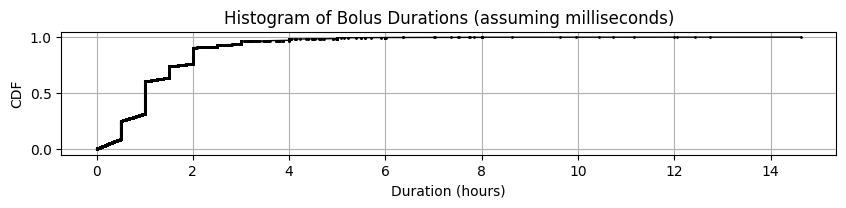

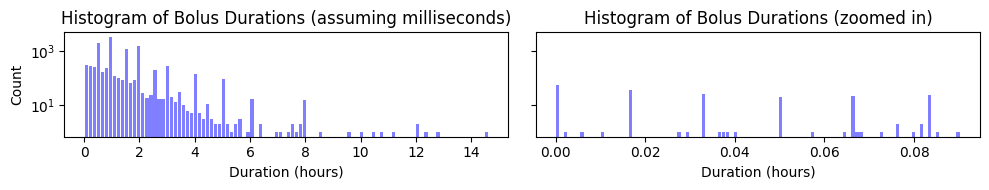

EXAMPLES of durations <0.01:


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,...,TmZnOffset,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceHardwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
1025711,270,959525,2019-07-23 07:35:00,2019-07-23 14:35:00,dual/square,0.5,NaN,0.42,0.5,0.0,...,-420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066762,270,959525,2019-07-31 10:35:00,2019-07-31 17:35:00,dual/square,0.5,NaN,0.16,0.5,0.0,...,-420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
#draw distributions assuming Duration is in milliseconds
durations = df_bolus.Duration.dropna().values/(1000*3600)
plt.figure(figsize=(10, 1.6)); ax = plt.gca()
cdf.plot_cdf(durations, xlabel='Duration (hours)',ax=ax)
plt.title('Histogram of Bolus Durations (assuming milliseconds)')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), sharey=True)
ax1.hist(durations, bins=100, alpha=0.5, rwidth=0.8, color='blue')
ax1.set_yscale('log')
ax1.set_xlabel('Duration (hours)')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of Bolus Durations (assuming milliseconds)')

ax2.hist(durations[durations < 0.1], bins=100, alpha=0.5, rwidth=0.8, color='blue')
#ax2.set_xlim(0, 0.1)
ax2.set_yscale('log'); ax2.set_xlabel('Duration (hours)')
ax2.set_title('Histogram of Bolus Durations (zoomed in)')
plt.tight_layout()
plt.show()

print('EXAMPLES of durations <0.01:')
display(df_bolus.loc[(df_bolus.Extended>0) & (df_bolus.Duration<0.01)].head(2))
del durations

It doe not look like the data would be split in ms and minutes (there is no skewed peak around 0). And duration values in the graph above, of 0.1h, would originate from a Duration of 60.000 if it were minutes. 

Now we know that Duration is the extended bolus duration. We need to split the row in an immediate and a extended part.
We could do this efficiently by just creating new rows for the Extended parts. Normal parts get assigned duration of 0 while the Extended part becomes a bolus keeping the duration. 

In [147]:
# Example how to concatenate the normal and extended boluses
data = {
    "Datetime": ["2024-01-01 00:00", "2024-01-01 01:00", "2024-01-01 02:00"],
    "Normal": [10, 15, 20],
    "Extended": [np.NaN, 5, np.NaN],
    "Duration": [np.NaN, 30, np.NaN]
}
df = pd.DataFrame(data)
df["Datetime"] = pd.to_datetime(df["Datetime"])

normal = df[["Datetime", "Normal"]]
normal.loc[:,'Duration'] = 0

extended = df.dropna(subset=['Extended'])[["Datetime", "Extended", 'Duration']].rename(columns={"Extended": "Normal"})

pd.concat([normal, extended], axis=0).sort_values('Datetime')
del data, df, normal, extended

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_48568/2075177681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal.loc[:,'Duration'] = 0


### Local Time Verification

In [ ]:
df_bolus = df_bolus.merge(df_patient[['PtID','PtTimezoneOffset']], on='PtID', how='left')
df_bolus['datetime'] = df_bolus.UTCDtTm + pd.to_timedelta(df_bolus.PtTimezoneOffset, unit='hour')

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_50366/815972233.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('cuts').Normal.mean().plot()


<Axes: xlabel='cuts'>

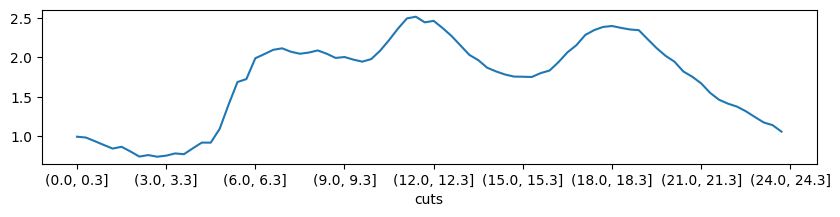

In [137]:
def get_hour_of_day(datetime_series):
    return datetime_series.dt.hour + datetime_series.dt.minute/60 + datetime_series.dt.second/3600
temp = df_bolus.sample(frac=0.5)
temp['cuts'] = pd.cut(get_hour_of_day(df_bolus.datetime), np.arange(0,25,0.3))
plt.figure(figsize=(10, 2)); ax = plt.gca()
temp.groupby('cuts').Normal.mean().plot()

In [105]:
#calcualte centered moving average
window = 2000
ma  = temp[['Normal','hour_of_day']].sort_values('datetime_hod').rolling(window=window, min_periods=window, on='datetime_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(ma_DeviceDtTm.DeviceDtTm_hod, ma_DeviceDtTm.CGMVal, label='DeviceDtTm', color='darkgray', marker='o',s=20)
plt.scatter(ma_UTCDtTm.UTCDtTm_hod, ma_UTCDtTm.CGMVal, label='UTCDtTm', color='blue', marker='x',s=2)
plt.scatter(ma_datetime.datetime_hod, ma_datetime.CGMVal, label='UTCDtTm + TmZnOffset', color='red', marker='.',s=2)

plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,...,OriginType,OriginDeviceFirmwrVer,OriginDeviceHardwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType,PtTimezoneOffset,datetime,hour_of_day
0,1082,22460,NaN,2018-04-20 06:01:58,normal,1.50,NaN,NaN,NaN,NaN,...,service,subg_rfspy 0.9,NaN,Medtronic,722,12.1.0,"iPhone11,8",-5.0,2018-04-20 01:01:58,1.032778
1,1082,22460,NaN,2018-04-20 00:43:53,normal,0.80,NaN,NaN,NaN,NaN,...,service,subg_rfspy 0.9,NaN,Medtronic,722,12.1.0,"iPhone11,8",-5.0,2018-04-19 19:43:53,19.731389
2,1082,22460,NaN,2018-04-19 22:56:56,normal,1.80,NaN,NaN,NaN,NaN,...,service,subg_rfspy 0.9,NaN,Medtronic,722,12.1.0,"iPhone11,8",-5.0,2018-04-19 17:56:56,17.948889
3,1082,22460,NaN,2018-04-19 22:36:08,normal,1.50,NaN,NaN,NaN,NaN,...,service,subg_rfspy 0.9,NaN,Medtronic,722,12.1.0,"iPhone11,8",-5.0,2018-04-19 17:36:08,17.602222
4,1082,22460,NaN,2018-04-19 19:58:50,normal,3.50,NaN,NaN,NaN,NaN,...,service,subg_rfspy 0.9,NaN,Medtronic,722,12.1.0,"iPhone11,8",-5.0,2018-04-19 14:58:50,14.980556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722508,1121,1468818,NaN,2019-12-17 12:14:46,normal,9.90,NaN,NaN,NaN,NaN,...,service,2.9.0,NaN,Insulet,Eros,13.3.0,"iPhone9,1",-5.0,2019-12-17 07:14:46,7.246111
2722509,1121,1468818,NaN,2019-12-16 03:17:08,normal,0.50,NaN,NaN,NaN,NaN,...,service,2.9.0,NaN,Insulet,Eros,13.3.0,"iPhone9,1",-5.0,2019-12-15 22:17:08,22.285556
2722510,1121,1468818,NaN,2019-12-14 00:08:18,normal,7.75,NaN,NaN,NaN,NaN,...,service,2.9.0,NaN,Insulet,Eros,13.3.0,"iPhone9,1",-5.0,2019-12-13 19:08:18,19.138333
2722511,1121,1468818,NaN,2019-12-12 04:12:45,normal,0.60,NaN,NaN,NaN,NaN,...,service,2.9.0,NaN,Insulet,Eros,13.3.0,"iPhone9,1",-5.0,2019-12-11 23:12:45,23.212500


### Conclusion 

* There are some duplicated temporal Boluses ~3% 
* These boluses are mostly equal but in rare cases significantly different (reason unclear)
* Extended boluses exist and should be separted, it appears that Duration is always given in milliseconds


## Basal

In [148]:
## export Basal to parquet if not already done
basal_parquet_path = os.path.join(loop_paquet_path, 'basal')

if not os.path.exists(basal_parquet_path):
    basal_columns = ['PtID', 'UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration', 'Percnt', 'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate', 'TmZnOffset']
    ddf_basal = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBasal*.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                        usecols=basal_columns)
    ddf_basal.to_parquet(os.path.join(basal_parquet_path, 'basal'), partition_on='PtID')
else:
    print(f'Parquet files already exist in {basal_parquet_path}')

Parquet files already exist in /Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/paquet/Loop study public dataset 2023-01-31/basal


In [151]:
#load parquet and a subset
ddf_basal = dd.read_parquet(basal_parquet_path, aggregate_files='PtID')
df_basal_sample = ddf_basal.sample(frac=0.1).compute().reset_index()

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 9.81 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [155]:
## Report Columns, Nans, Duplicates, 

print('COLUMNS:')
print(df_basal_sample.columns)

print('NAN FRACTIONS')
display(100*df_basal_sample.isna().sum()/len(df_basal_sample))

print('DUPLICATES:')
report_duplicates(df_basal_sample, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

print('VALUE FRACTIONS:')
display(df_basal_sample.value_counts(subset=['BasalType'])*100/len(df_basal_sample))
display(df_basal_sample.value_counts(subset=['SuprBasalType'])*100/len(df_basal_sample))

print('DESCRIPTIONS:')
display(df_basal_sample.Percnt.describe())
display(df_basal_sample.Rate.describe())

COLUMNS:
Index(['index', 'UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration',
       'Percnt', 'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate',
       'TmZnOffset', 'PtID'],
      dtype='object')
NAN FRACTIONS


index                0.000000
UTCDtTm              0.000000
BasalType            0.000000
Duration             0.000000
ExpectedDuration    99.799592
Percnt              99.914309
Rate                 0.038881
SuprBasalType       24.145759
SuprDuration        99.963189
SuprRate            24.145863
TmZnOffset          99.213293
PtID                 0.000000
dtype: float64

DUPLICATES:
0 duplicates (0.00%)
Duplicated rows:


,index,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID


4642 duplicates (0.10%) ['UTCDtTm', 'PtID']
Duplicated rows subset ['UTCDtTm', 'PtID']:


,index,UTCDtTm,BasalType,Duration,PtID
3808711,331360,2017-11-24 08:26:27,temp,300000,993
3803932,331359,2017-11-24 08:26:27,temp,300000,993


VALUE FRACTIONS:


BasalType
temp         99.498875
scheduled     0.271090
automated     0.191154
suspend       0.038881
Name: count, dtype: float64

SuprBasalType
scheduled        75.851839
temp              0.001242
automated         0.001159
Name: count, dtype: float64

DESCRIPTIONS:


count    4139.000000
mean        1.118751
std         0.718900
min         0.000000
25%         0.500000
50%         1.150000
75%         1.551500
max         7.550000
Name: Percnt, dtype: float64

count    4.828258e+06
mean     1.076148e+00
std      1.505409e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.040000e-01
75%      1.742000e+00
max      4.000000e+01
Name: Rate, dtype: float64

In very few cases, the suppressed basal rate is a temporary or automated basal rate. It is unclear where these come from, potentially set on the pump itself.

In [156]:
df_basal_sample.dropna(subset=['Percnt'])

,index,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID
74657,23075,2018-09-25 19:54:18,temp,3600000,NaN,1.95,0.48,scheduled,3600000.0,0.25,-360.0,18
74826,23336,2018-10-02 16:31:36,temp,3600000,NaN,1.95,0.48,scheduled,3600000.0,0.25,-300.0,18
74972,5467,2018-08-05 03:34:04,temp,1556000,3600000.0,0.25,0.11,scheduled,3600000.0,0.44,-300.0,18
75076,23436,2018-11-12 04:05:49,temp,3251000,3600000.0,1.50,0.52,scheduled,3600000.0,0.35,-300.0,18
75573,5746,2018-08-01 03:16:54,temp,2586000,3600000.0,1.95,0.87,scheduled,3600000.0,0.45,-300.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...
4810576,388129,2019-03-21 00:23:38,temp,3600000,NaN,1.50,0.22,scheduled,3600000.0,0.15,-420.0,1209
4812615,387389,2019-03-26 02:19:13,temp,3600000,NaN,1.50,0.30,scheduled,3600000.0,0.20,-420.0,1209
4812677,387180,2019-03-22 05:09:26,temp,609000,660000.0,1.50,0.22,scheduled,660000.0,0.15,-420.0,1209
4812873,387163,2019-03-22 23:06:42,temp,3600000,NaN,1.25,0.18,scheduled,3600000.0,0.14,-420.0,1209


## Todos
* Check if Datetime+duration > next Datetime --> 
* Look at distributions for basal, bolus to check local time assumptions